In [5]:
!unrar x "/content/train_image.rar" "/content/train_image/"

Output streaming akan dipotong hingga 5000 baris terakhir.
Extracting  /content/train_image/train_image/Arborio(280)_json/masking_grain.png      51%  OK 
Creating    /content/train_image/train_image/Arborio(281)_json        OK
Extracting  /content/train_image/train_image/Arborio(281)_json/img.png      51%  OK 
Extracting  /content/train_image/train_image/Arborio(281)_json/label.png      51%  OK 
Extracting  /content/train_image/train_image/Arborio(281)_json/label_names.txt      51%  OK 
Extracting  /content/train_image/train_image/Arborio(281)_json/label_viz.png      51%  OK 
Extracting  /content/train_image/train_image/Arborio(281)_json/masking_chalkie.png      51%  OK 
Extracting  /content/train_image/train_image/Arborio(281)_json/masking_grain.png      51%  OK 
Creating    /content/train_image/train_image/Arborio(282)_json        OK
Extracting  /content/train_image/train_image/Arborio(282)_json/img.png      51% 

In [6]:
import tensorflow as tf
import os
# from google.colab import drive
# drive.mount('/content/drive')
import glob
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def conv_block(inputs, filters, kernel_size, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def residual_block(inputs, filters, kernel_size, activation='linear', padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    shortcut = inputs
    if inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, (1, 1), activation=activation, padding=padding)(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    return x

def upsample_concat_block(x, xskip):
    u = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.Concatenate()([u, xskip])
    return c



def UnetPlusPlus(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
#     s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    # Encoder
    c1 = residual_block(inputs, 16, 3)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 32, 3)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 64, 3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 128, 3)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = residual_block(p4, 256, 3)

    # Decoder Segmentation
    u6 = upsample_concat_block(c5, c4)
    c6 = residual_block(u6, 128, 3)

    u7 = upsample_concat_block(c6, c3)
    c7 = residual_block(u7, 64, 3)

    u8 = upsample_concat_block(c7, c2)
    c8 = residual_block(u8, 32, 3)

    u9 = upsample_concat_block(c8, c1)
    c9 = residual_block(u9, 16, 3)

    outputs_segmentation = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid', name='segmentation')(c9)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs_segmentation)

    return model

In [14]:
image_path

['train_image']

In [17]:
path = '/content/train_image/train_image'

image_p = os.listdir(path)
image_path = [i for i in image_p]

train_image = []
for i, v in tqdm(enumerate(image_path)):
  jalan = f'/content/train_image/train_image/{v}/img.png'
  img = cv2.imread(jalan)
  img = cv2.resize(img, (224, 224))
  train_image.append(img)

train_images = np.array(train_image)


train_mask = []
for i, v in tqdm(enumerate(image_path)):
  jalan_label = f'/content/train_image/train_image/{v}/masking_chalkie.png'
  img_label =  cv2.imread(jalan_label, 0)
  img_label = cv2.resize(img_label, (224, 224))
  train_mask.append(img_label)
train_masks = np.array(train_mask)
train_masks = np.stack([train_masks] * 3, axis=-1)

train_images = train_images.astype('float32')
train_masks = train_masks.astype('float32')

train_images = train_images/255
train_masks = train_masks/255

print(f'''
{train_images.shape}

{train_masks.shape}
''')

1459it [00:01, 1057.92it/s]
1459it [00:01, 1146.58it/s]



(1459, 224, 224, 3)

(1459, 224, 224, 3)



In [18]:
tf.keras.backend.clear_session()
K = tf.keras.backend

class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(K.flatten(y_true), tf.float32)  # Convert y_true to float32
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

model = UnetPlusPlus(
    input_shape=(224, 224, 3),
)

model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=dice_coef
)

In [19]:
history = model.fit(
    train_images, train_masks, epochs=5,
    validation_split=0.2
)

Epoch 1/5
37/37 [==============================] - 49s 491ms/step - loss: 0.4113 - dice_coef: 0.9564 - val_loss: 0.7413 - val_dice_coef: 0.8056
Epoch 2/5
37/37 [==============================] - 12s 334ms/step - loss: 0.0821 - dice_coef: 0.9827 - val_loss: 0.2519 - val_dice_coef: 0.9253
Epoch 3/5
37/37 [==============================] - 12s 323ms/step - loss: 0.0798 - dice_coef: 0.9831 - val_loss: 0.1468 - val_dice_coef: 0.9574
Epoch 4/5
37/37 [==============================] - 12s 337ms/step - loss: 0.0700 - dice_coef: 0.9843 - val_loss: 0.1050 - val_dice_coef: 0.9707
Epoch 5/5
37/37 [==============================] - 12s 327ms/step - loss: 0.0692 - dice_coef: 0.9845 - val_loss: 0.0943 - val_dice_coef: 0.9746


In [162]:
y_pred = model.predict(train_images)
y_pred.shape

46/46 [==============================] - 4s 88ms/step


(1459, 224, 224, 3)

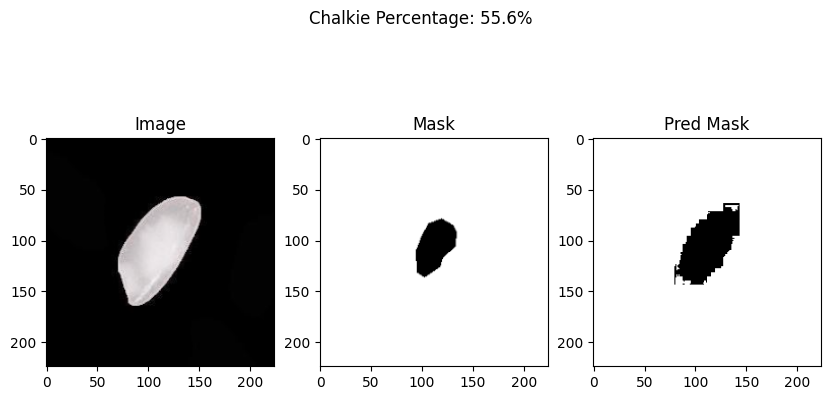

In [213]:
import matplotlib.pyplot as plt

# Assuming train_image[32] and train_masks[32] are your images
i = np.random.randint(0, len(train_images))
image = train_images[i]
mask = train_masks[i]
pred_mask = y_pred[i]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the image on the left subplot
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Image')

# Plot the mask on the right subplot
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')

# Plot the mask on the right subplot
mean_pred_mask = np.mean(pred_mask, axis=2)
mean_pred_mask = np.where(mean_pred_mask>.5, 1, 0)

axs[2].imshow(mean_pred_mask, cmap='gray')
axs[2].set_title('Pred Mask')

y_true_percentage = np.where(image>.5, 1.0, 0.0)[:, :, 0]
y_pred_percentage = mean_pred_mask

intersection = K.sum(y_true_percentage * y_pred_percentage)
chalkie_percentage = 1-(intersection.numpy()/K.sum(y_true_percentage).numpy())

# Display the figure
fig.suptitle(f'Chalkie Percentage: {round(chalkie_percentage * 100, 2)}%')
plt.show()

In [207]:
jalan = f'/content/Arborio_13228.jpg'
img = cv2.imread(jalan)
img = cv2.resize(img, (224, 224))
img = img.astype('float32')/255
img = img[np.newaxis]

1/1 [==============================] - 0s 25ms/step


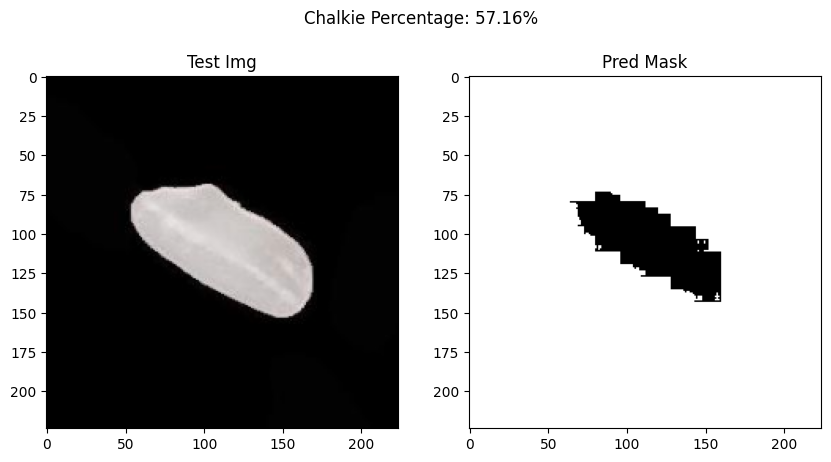

In [208]:
test_pred = model.predict(img)[0]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mask on the right subplot
axs[0].imshow(img[0], cmap='gray')
axs[0].set_title('Test Img')

# Plot the mask on the right subplot
mean_pred_mask = np.mean(test_pred, axis=2)
mean_pred_mask = np.where(mean_pred_mask>.5, 1, 0)

axs[1].imshow(mean_pred_mask, cmap='gray')
axs[1].set_title('Pred Mask')

y_true_percentage = np.where(img[0]>.5, 1.0, 0.0)[:, :, 0]
y_pred_percentage = mean_pred_mask

intersection = K.sum(y_true_percentage * y_pred_percentage)
chalkie_percentage = 1-(intersection.numpy()/K.sum(y_true_percentage).numpy())

# Display the figure
fig.suptitle(f'Chalkie Percentage: {round(chalkie_percentage * 100, 2)}%')
plt.show()

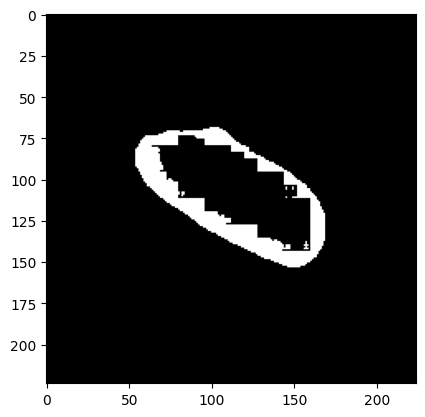

In [209]:
plt.imshow(y_true_percentage * y_pred_percentage, cmap='gray')

In [205]:
import shutil

# Replace 'folder_name' with the name of your folder
folder_name = '/content/Chalkie-Percentage-Segmentation.keras'

# Zip the folder
shutil.make_archive(folder_name, 'zip', folder_name)

'/content/Chalkie-Percentage-Segmentation.zip'